In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV



In [2]:
df = pd.read_csv('data/malicious_phish.csv')

display(df)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [3]:
#https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset/discussion/431505
#https://research.aalto.fi/en/datasets/phishstorm-phishing-legitimate-url-dataset

df2 = pd.read_csv('data/urlset.csv', on_bad_lines='skip', low_memory=False)
df2 = df2[['domain', 'label']]
df_merge = df.merge(df2, how = 'left', left_on = 'url', right_on = 'domain')

df_merge.loc[df_merge['label']==0, 'type'] = 'benign'
df_merge.loc[df_merge['label']==1, 'type'] = 'phishing'
df = df_merge[['url', 'type']]

df = df.drop_duplicates()
display(df)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651190,xbox360.ign.com/objects/850/850402.html,benign
651191,games.teamxbox.com/xbox-360/1860/Dead-Space/,benign
651192,www.gamespot.com/xbox360/action/deadspace/,benign
651193,en.wikipedia.org/wiki/Dead_Space_(video_game),benign


### Preprocessing

In [4]:
df.isnull().sum()

url     0
type    0
dtype: int64

##### Feature Extraction

In [5]:
def alphabet_ratio(url):
    url_length = len(url)
    alphabet_count = len(re.findall('[A-Za-z]',url))
    ratio = alphabet_count/ url_length
    return ratio

In [6]:
def digit_ratio(url):
    url_length = len(url)
    digit_count = len(re.findall('[\\d+]',url))
    ratio = digit_count/ url_length
    return ratio

In [7]:
def non_alphanumeric_ratio(url):
    url_length = len(url)
    non_alphanumeric_count = len(re.findall('[^a-zA-Z0-9]', url))
    ratio = non_alphanumeric_count/ url_length
    return ratio

In [8]:
def dot_count(url):
    return len(re.findall('[.]', url))

def dash_count(url):
    return len(re.findall('[-]', url))

def underscore_count(url):
    return len(re.findall('[_]', url))

def slash_count(url):
    return len(re.findall('[/]', url))

def q_mark_count(url):
    return len(re.findall('[?]', url))

def percentage_count(url):
    return len(re.findall('[%]', url))



In [9]:
def http (url):
    return int(len(re.findall('(http)[^s]', url)) > 0)

def https (url):
    return int(len(re.findall('https', url)) > 0)

def php (url):
    return int(len(re.findall('php', url)) > 0)

def html (url):
    return int(len(re.findall('html', url)) > 0)



In [10]:
def feature_extraction(df, col):
    df_copy = df.copy()
    df_copy['length'] = df[col].apply(len)
    df_copy['alphabet_ratio'] = df[col].apply(alphabet_ratio)
    df_copy['digit_ratio'] = df[col].apply(digit_ratio)
    df_copy['non_alphanumeric_ratio'] = df[col].apply(non_alphanumeric_ratio)
    df_copy['dot_count'] = df[col].apply(dot_count)
    df_copy['underscore_count'] = df[col].apply(underscore_count)
    df_copy['slash_count'] = df[col].apply(slash_count)
    df_copy['q_mark_count'] = df[col].apply(q_mark_count)
    df_copy['percentage_count'] = df[col].apply(percentage_count)
    df_copy['http'] = df[col].apply(http)
    df_copy['https'] = df[col].apply(https)
    df_copy['html'] = df[col].apply(html)
    df_copy['php'] = df[col].apply(php)
   

    return df_copy
    

    

In [11]:
df_extracted = feature_extraction(df,'url')
df_extracted.head()

,url,type,length,alphabet_ratio,digit_ratio,non_alphanumeric_ratio,dot_count,underscore_count,slash_count,q_mark_count,percentage_count,http,https,html,php
0,br-icloud.com.br,phishing,16,0.812500,0.000000,0.187500,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0.828571,0.028571,0.142857,2,1,2,0,0,0,0,1,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0.806452,0.032258,0.161290,2,0,3,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0.715909,0.079545,0.204545,3,2,3,1,0,1,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0.846809,0.093617,0.059574,2,1,3,1,0,1,0,0,1


In [12]:
df_extracted.loc[df_extracted['type'] == 'benign',('type')]  = 0
df_extracted.loc[df_extracted['type'] == 'defacement',('type')]  = 1
df_extracted.loc[df_extracted['type'] == 'phishing',('type')]  = 2
df_extracted.loc[df_extracted['type'] == 'malware',('type')]  = 3
df_extracted['type'] = df_extracted['type'].astype(int)

In [13]:
df_extracted = df_extracted[['length', 'alphabet_ratio', 'digit_ratio',
       'non_alphanumeric_ratio', 'dot_count', 'underscore_count',
       'slash_count', 'q_mark_count', 'percentage_count', 'http', 'https',
       'html', 'php','type']]



In [14]:
features_df = df_extracted[['length', 'alphabet_ratio', 'digit_ratio',
       'non_alphanumeric_ratio', 'dot_count', 'underscore_count',
       'slash_count', 'q_mark_count', 'percentage_count', 'http', 'https',
       'html', 'php']]

label_df = df_extracted['type']

In [15]:
label_df.head()

0    2
1    0
2    0
3    1
4    1
Name: type, dtype: int32

#### Train, Validation, Test Split

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_df, label_df, test_size=0.25, stratify=label_df, random_state = 1)


In [17]:
X_train.head()

,length,alphabet_ratio,digit_ratio,non_alphanumeric_ratio,dot_count,underscore_count,slash_count,q_mark_count,percentage_count,http,https,html,php
109075,25,0.880000,0.000000,0.120000,1,1,1,0,0,0,0,0,0
320026,35,0.857143,0.000000,0.142857,2,1,2,0,0,0,0,0,0
136144,76,0.763158,0.052632,0.184211,3,1,3,1,0,1,0,1,0
186158,72,0.805556,0.083333,0.111111,1,0,2,0,0,0,0,0,0
303363,30,0.866667,0.000000,0.133333,2,0,2,0,0,0,0,0,0


In [18]:
list(X_train.columns)

['length',
 'alphabet_ratio',
 'digit_ratio',
 'non_alphanumeric_ratio',
 'dot_count',
 'underscore_count',
 'slash_count',
 'q_mark_count',
 'percentage_count',
 'http',
 'https',
 'html',
 'php']

#### Data Scaling

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

### Linear SVC with SGD


In [20]:
from sklearn.linear_model import SGDClassifier

parameters = {"alpha":np.logspace(-6, 6, num = 20)}
linear_svc = SGDClassifier(loss= 'hinge', n_jobs= -1)
clf = GridSearchCV(linear_svc, parameters, verbose= 2, cv = 3, n_jobs= -1)
clf.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=SGDClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 4.28133240e-06, 1.83298071e-05, 7.84759970e-05,
       3.35981829e-04, 1.43844989e-03, 6.15848211e-03, 2.63665090e-02,
       1.12883789e-01, 4.83293024e-01, 2.06913808e+00, 8.85866790e+00,
       3.79269019e+01, 1.62377674e+02, 6.95192796e+02, 2.97635144e+03,
       1.27427499e+04, 5.45559478e+04, 2.33572147e+05, 1.00000000e+06])},
             verbose=2)

In [21]:

linear_svc = SGDClassifier(alpha = clf.best_params_['alpha'], loss= 'hinge', n_jobs= -1)
linear_svc.fit(X_train_scaled, y_train)

SGDClassifier(alpha=4.281332398719396e-06, n_jobs=-1)

In [22]:
pickle.dump(linear_svc,open('linear_svc.pkl', 'wb'))

In [23]:
linear_svc = pickle.load(open('linear_svc.pkl','rb'))

In [24]:
y_pred = linear_svc.predict(X_test_scaled)

              precision    recall  f1-score   support

           0       0.86      0.97      0.91    107046
           1       0.79      0.98      0.87     23827
           2       0.72      0.13      0.22     23496
           3       0.75      0.78      0.77      5911

    accuracy                           0.84    160280
   macro avg       0.78      0.71      0.69    160280
weighted avg       0.82      0.84      0.80    160280



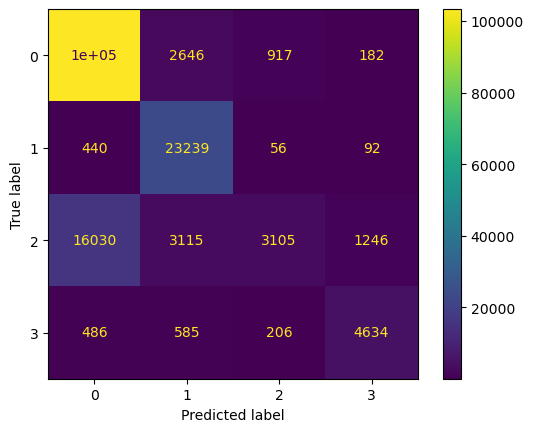

In [25]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=linear_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=linear_svc.classes_)
disp.plot()

plt.show()

### Logistic Regression

In [33]:
from sklearn.linear_model import SGDClassifier

parameters = {"alpha":np.logspace(-6, 6, num = 20)}
logistic_clf = SGDClassifier(loss="log_loss", max_iter=1000)
clf = GridSearchCV(logistic_clf, parameters, verbose= 3, cv = 3, n_jobs= -1)
clf.fit(X_train_scaled, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=SGDClassifier(loss='log_loss'), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 4.28133240e-06, 1.83298071e-05, 7.84759970e-05,
       3.35981829e-04, 1.43844989e-03, 6.15848211e-03, 2.63665090e-02,
       1.12883789e-01, 4.83293024e-01, 2.06913808e+00, 8.85866790e+00,
       3.79269019e+01, 1.62377674e+02, 6.95192796e+02, 2.97635144e+03,
       1.27427499e+04, 5.45559478e+04, 2.33572147e+05, 1.00000000e+06])},
             verbose=3)

In [34]:
pickle.dump(clf,open('log_clf','wb'))

In [35]:
clf = pickle.load(open('log_clf','rb'))

In [37]:
logistic_clf = SGDClassifier(alpha = clf.best_params_['alpha'], loss= 'log_loss', n_jobs= -1)

logistic_clf.fit(X_train_scaled, y_train)


SGDClassifier(alpha=7.847599703514606e-05, loss='log_loss', n_jobs=-1)

In [38]:
y_pred = logistic_clf.predict(X_test_scaled)

              precision    recall  f1-score   support

           0       0.87      0.97      0.91    107046
           1       0.82      0.96      0.88     23827
           2       0.73      0.22      0.34     23496
           3       0.82      0.77      0.79      5911

    accuracy                           0.85    160280
   macro avg       0.81      0.73      0.73    160280
weighted avg       0.84      0.85      0.82    160280



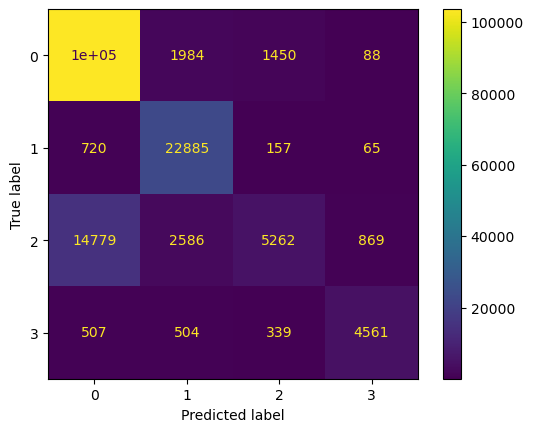

In [39]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=logistic_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logistic_clf.classes_)
disp.plot()

plt.show()

### Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(random_state=0)
# clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=0)

In [20]:
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    params = {'n_estimators':trial.suggest_int('n_estimators',100,1000, step = 10),
              'max_depth':trial.suggest_int('max_depth',5,50),
              'n_jobs':-1,
              'random_state': 6740,
              'max_features': trial.suggest_float('max_features', 0.1, 1.0),
              'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
              'oob_score':True
                }
    clf = RandomForestClassifier(**params)

    clf.fit(X_train_scaled, y_train)
    score = clf.oob_score_
    
    return score

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-04-25 22:38:36,319] A new study created in memory with name: no-name-4f2bc56e-212a-4370-9fa8-1ed8d02a22d7
[I 2025-04-25 22:40:46,558] Trial 0 finished with value: 0.9430682619338282 and parameters: {'n_estimators': 440, 'max_depth': 31, 'max_features': 0.8030256980754322, 'min_samples_split': 50, 'min_samples_leaf': 29}. Best is trial 0 with value: 0.9430682619338282.
[I 2025-04-25 22:43:28,476] Trial 1 finished with value: 0.9400901341197365 and parameters: {'n_estimators': 520, 'max_depth': 23, 'max_features': 0.9193413165307026, 'min_samples_split': 47, 'min_samples_leaf': 44}. Best is trial 0 with value: 0.9430682619338282.
[I 2025-04-25 22:44:33,122] Trial 2 finished with value: 0.939948714642531 and parameters: {'n_estimators': 460, 'max_depth': 28, 'max_features': 0.2913778616081193, 'min_samples_split': 15, 'min_samples_leaf': 37}. Best is trial 0 with value: 0.9430682619338282.
[I 2025-04-25 22:47:44,898] Trial 3 finished with value: 0.9390752414009679 and parameters: 

In [27]:
best_param = study.best_trial.params
rf = RandomForestClassifier(**best_param)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=18, max_features=0.3277550027336104,
                       min_samples_leaf=8, min_samples_split=27,
                       n_estimators=870)

In [28]:
pickle.dump(rf,open('rf.pkl','wb'))

In [101]:
rf = pickle.load(open('rf.pkl','rb'))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    107046
           1       0.93      0.98      0.95     23827
           2       0.92      0.73      0.81     23496
           3       0.99      0.84      0.91      5911

    accuracy                           0.95    160280
   macro avg       0.95      0.88      0.91    160280
weighted avg       0.95      0.95      0.94    160280



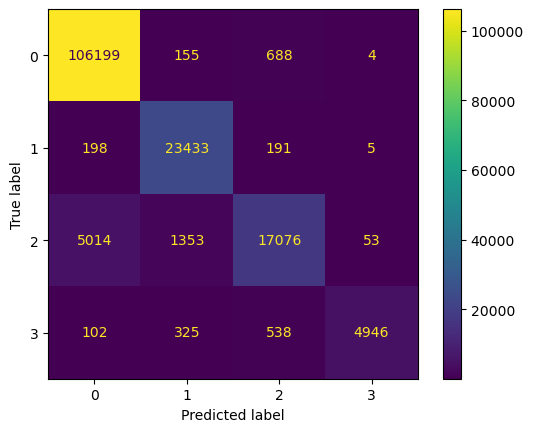

In [102]:
y_pred=rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot()

plt.show()

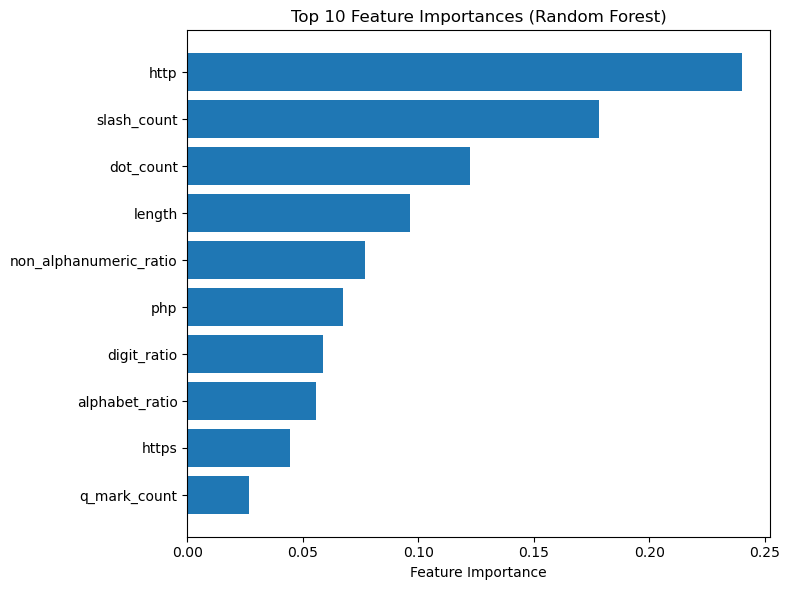

In [103]:
feature_names = [
    'length',
    'alphabet_ratio',
    'digit_ratio',
    'non_alphanumeric_ratio',
    'dot_count',
    'underscore_count',
    'slash_count',
    'q_mark_count',
    'percentage_count',
    'http',
    'https',
    'html',
    'php'
]

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for easier sorting
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(feat_importance_df['Feature'][:10], feat_importance_df['Importance'][:10])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# print("Best trial:")
# print(study.best_trial)

# print("Best parameters:")
# print(study.best_params)

# print("Best value:")
# print(study.best_value)

In [110]:
pickle.dump(clf,open('rf.pkl','wb'))

In [43]:
rf_clf = pickle.load(open('rf.pkl','rb'))

In [44]:
y_pred = rf_clf.predict(X_test_scaled)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    107046
           1       0.93      0.98      0.95     23827
           2       0.92      0.73      0.81     23496
           3       0.99      0.84      0.91      5911

    accuracy                           0.95    160280
   macro avg       0.95      0.88      0.91    160280
weighted avg       0.95      0.95      0.94    160280



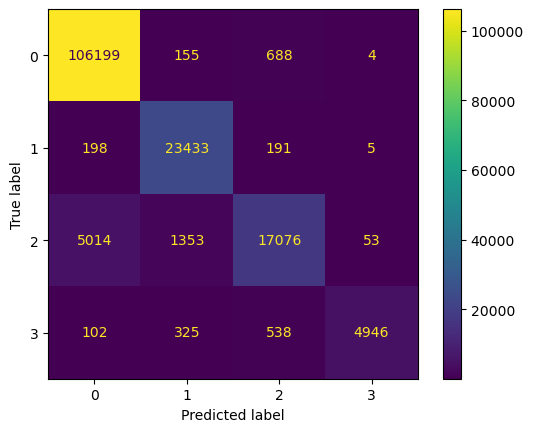

In [45]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_clf.classes_)
disp.plot()

plt.show()

### XGBoost

In [76]:
from sklearn.metrics import accuracy_score

In [89]:
import xgboost as xgb
def objective(trial):
    params = {
        'tree_method': 'gpu_hist',
        'objective':'multi:softmax',
        'eval_metric': 'mlogloss',  # good default for binary classification
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'use_label_encoder': False,  # avoid deprecation warning
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = xgb.XGBClassifier(**params)
    

    
    
    scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=-1)  
    
    return scores.mean()

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

In [85]:
best_param = study.best_trial.params
best_param

{'n_estimators': 789,
 'max_depth': 12,
 'learning_rate': 0.19661909349384402,
 'subsample': 0.9220618002983965,
 'colsample_bytree': 0.9669937331485129,
 'gamma': 0.01609155945914509,
 'reg_alpha': 3.0430325374795566,
 'reg_lambda': 3.1403292578386885}

In [93]:
xgboost = xgb.XGBClassifier(**best_param, device = 'cuda')
xgboost.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9669937331485129, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.01609155945914509, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.19661909349384402,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=789, n_jobs=None,
              num_parallel_tree=None, ...)

In [98]:
pickle.dump(xgboost,open('xgboost.pkl','wb'))

In [24]:
xgboost = pickle.load(open('xgboost.pkl','rb'))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    107046
           1       0.95      0.98      0.96     23827
           2       0.90      0.78      0.83     23496
           3       0.97      0.88      0.92      5911

    accuracy                           0.95    160280
   macro avg       0.94      0.91      0.92    160280
weighted avg       0.95      0.95      0.95    160280



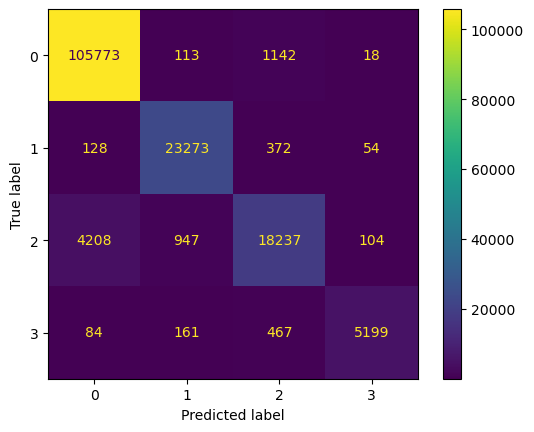

In [26]:
y_pred = xgboost.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=xgboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgboost.classes_)
disp.plot()

plt.show()

In [99]:
feature_names = [
    'length',
    'alphabet_ratio',
    'digit_ratio',
    'non_alphanumeric_ratio',
    'dot_count',
    'underscore_count',
    'slash_count',
    'q_mark_count',
    'percentage_count',
    'http',
    'https',
    'html',
    'php'
]

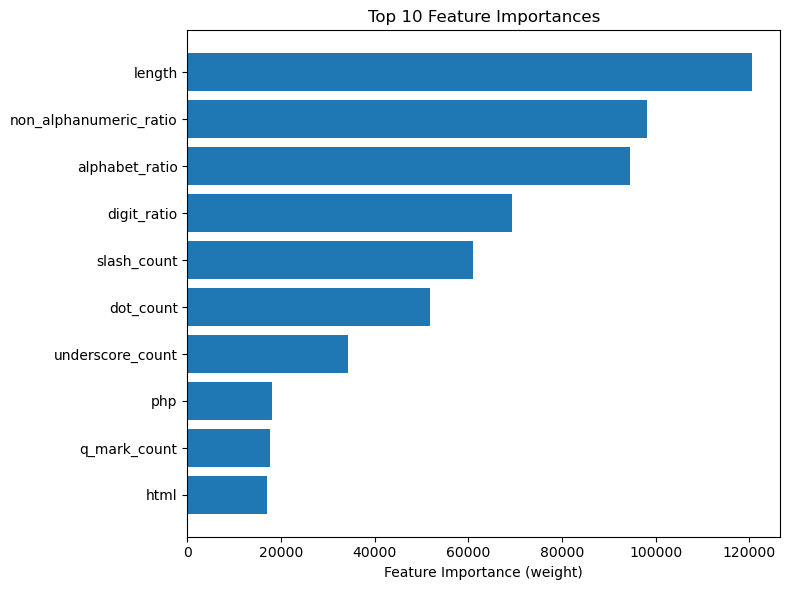

In [100]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming your trained model is called "model"
booster = xgboost.get_booster()

# Get feature importances
importance_dict = booster.get_score(importance_type='weight')

# Map f0, f1, f2... to real names
mapped_importance = {feature_names[int(k[1:])]: v for k, v in importance_dict.items()}

# Sort features by importance
sorted_features = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(
    [name for name, _ in sorted_features[:10]],  # top 10 features
    [score for _, score in sorted_features[:10]]
)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance (weight)')
plt.title('Top 10 Feature Importances')
plt.grid(False)
plt.tight_layout()
plt.show()


## One-Class SVM

In [19]:
X_train_ = X_train_scaled[y_train==0]
y_train_ = y_train[y_train == 0]

In [21]:
len(X_train_)

321137

In [ ]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(kernel = 'linear', nu=0.05)
clf.fit(X_train_)

In [23]:
pickle.dump(clf,open('one_class.pkl','wb'))

In [24]:
one_class = pickle.load(open('one_class.pkl','rb'))

In [25]:
y_pred = one_class.predict(X_test_scaled)

In [28]:
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1

In [29]:

y_test[y_test == 2] = 1
y_test[y_test == 3] = 1

              precision    recall  f1-score   support

           0       0.84      0.89      0.87    107046
           1       0.75      0.66      0.70     53234

    accuracy                           0.81    160280
   macro avg       0.80      0.78      0.78    160280
weighted avg       0.81      0.81      0.81    160280



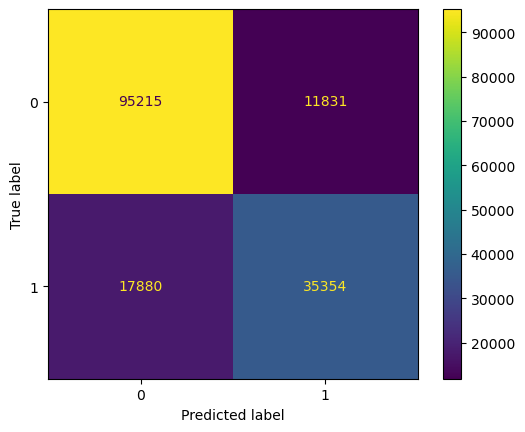

In [32]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

### RBF OCSVM (Subsampled)

In [27]:
from sklearn.svm import OneClassSVM

X_train_ = X_train_scaled[y_train==0]
y_train_ = y_train[y_train == 0]

In [33]:
X_subsample, _, y_subsample, _ = train_test_split(
    X_train_, y_train_,
    train_size=20000, 
    random_state=6740,  # for reproducibility
    stratify=None  # stratify not needed because all y_train_ == 0 (only one class)
)

In [39]:
ocsvm_rbf = OneClassSVM(kernel='rbf', nu=0.25)
ocsvm_rbf.fit(X_subsample)

OneClassSVM(nu=0.25)

In [40]:
y_pred = ocsvm_rbf.predict(X_test_scaled)



In [41]:
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1

y_test[y_test == 2] = 1
y_test[y_test == 3] = 1

              precision    recall  f1-score   support

           0       0.91      0.75      0.82    107046
           1       0.63      0.85      0.72     53234

    accuracy                           0.78    160280
   macro avg       0.77      0.80      0.77    160280
weighted avg       0.82      0.78      0.79    160280



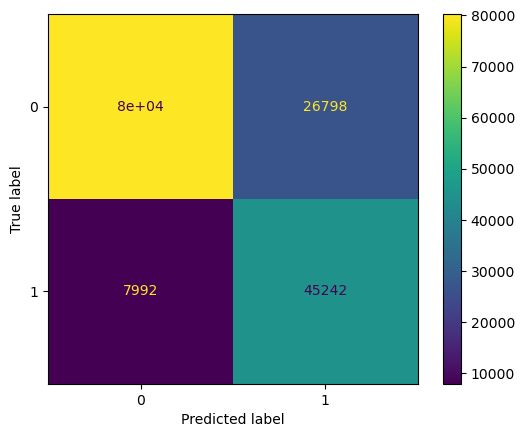

In [42]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

## Bag of Words Models

In [20]:
url_df = df['url']
url_df.head()

0                                     br-icloud.com.br
1                  mp3raid.com/music/krizz_kaliko.html
2                      bopsecrets.org/rexroth/cr/1.htm
3    http://www.garage-pirenne.be/index.php?option=...
4    http://adventure-nicaragua.net/index.php?optio...
Name: url, dtype: object

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(url_df, label_df, test_size=0.2, stratify=label_df, random_state = 1)

In [28]:
len(y_test)

128224

In [29]:
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 512895, Test size: 128224


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (2,3))
vectorizer.fit(X_train)
X_train_token = vectorizer.transform(X_train)
X_test_token = vectorizer.transform(X_test)


In [104]:
pickle.dump(X_train_token, open('X_train_token.pkl','wb'))

pickle.dump(X_test_token, open('X_test_token.pkl','wb'))

In [47]:
X_train_token = pickle.load(open('X_train_token.pkl','rb'))
X_test_token = pickle.load(open('X_test_token.pkl','rb'))


In [106]:
X_train_token.shape

(480839, 105589)

### Linear SVC with SGD

In [110]:
from sklearn.linear_model import SGDClassifier

parameters = {"alpha":np.logspace(-6, 6, num = 20)}
linear_svc_bow = SGDClassifier(loss= 'hinge', n_jobs= -1)
clf = GridSearchCV(linear_svc, parameters, verbose= 2, cv = 3, n_jobs= -1)
clf.fit(X_train_token, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3,
             estimator=SGDClassifier(alpha=4.281332398719396e-06, n_jobs=-1),
             n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 4.28133240e-06, 1.83298071e-05, 7.84759970e-05,
       3.35981829e-04, 1.43844989e-03, 6.15848211e-03, 2.63665090e-02,
       1.12883789e-01, 4.83293024e-01, 2.06913808e+00, 8.85866790e+00,
       3.79269019e+01, 1.62377674e+02, 6.95192796e+02, 2.97635144e+03,
       1.27427499e+04, 5.45559478e+04, 2.33572147e+05, 1.00000000e+06])},
             verbose=2)

In [111]:
pickle.dump(clf, open('linear_svc_sgd_bow.pkl','wb'))

In [ ]:
clf = pickle.load(open('linear_svc_sgd_bow.pkl','rb'))

In [115]:
best_param = clf.best_params_

In [117]:
linear_svc_bow = SGDClassifier(**best_param, n_jobs= -1, loss = 'hinge')
linear_svc_bow.fit(X_train_token, y_train)

SGDClassifier(alpha=1.8329807108324375e-05, n_jobs=-1)

In [118]:
y_pred = linear_svc_bow.predict(X_test_token)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    107046
           1       0.99      1.00      1.00     23827
           2       0.96      0.94      0.95     23496
           3       0.99      0.93      0.96      5911

    accuracy                           0.99    160280
   macro avg       0.98      0.97      0.97    160280
weighted avg       0.99      0.99      0.99    160280



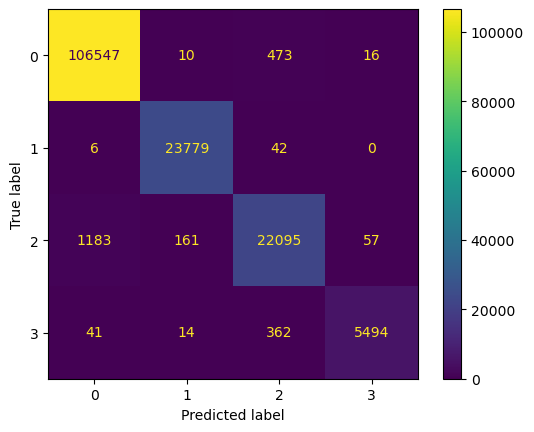

In [119]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=linear_svc_bow.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=linear_svc_bow.classes_)
disp.plot()

plt.show()

### Random Forest

In [120]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=0, n_jobs = -1)
rf_clf.fit(X_train_token, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [121]:
pickle.dump(rf_clf, open('rf_BoW_clf','wb'))

In [122]:
rf_clf = pickle.load(open('rf_BoW_clf','rb'))

In [123]:
y_pred = rf_clf.predict(X_test_token)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    107046
           1       0.98      1.00      0.99     23827
           2       0.97      0.89      0.93     23496
           3       1.00      0.92      0.95      5911

    accuracy                           0.98    160280
   macro avg       0.98      0.95      0.97    160280
weighted avg       0.98      0.98      0.98    160280



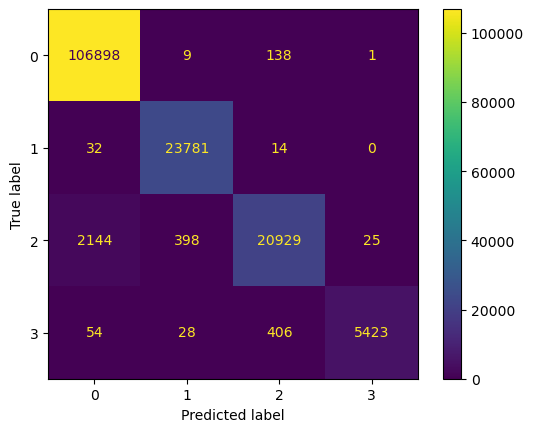

In [124]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_clf.classes_)
disp.plot()

plt.show()

### XGBoost

In [36]:
import xgboost as xgb
def objective(trial):
    params = {
        'device': 'cuda',
        'objective':'multi:softmax',
        'eval_metric': 'mlogloss',  
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'use_label_encoder': False,  
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = xgb.XGBClassifier(**params)
    

    
    
    scores = cross_val_score(model, X_train_token, y_train, cv=3, scoring='accuracy', n_jobs=-1)  
    
    return scores.mean()

In [41]:
import xgboost as xgb

model = xgb.XGBClassifier(
    tree_method='hist',  
    device = 'cuda',          
    objective='multi:softmax',     
    eval_metric='mlogloss',        
    random_state=42,
    colsample_bytree=0.3,
    n_jobs=-1, )

model.fit(
    X_train_token, y_train,
    verbose=True               
)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

In [42]:
pickle.dump(model,open('xgboost_bow','wb'))

In [31]:
xgb_bow = pickle.load(open('xgboost_bow','rb'))

In [32]:
y_pred = xgb_bow.predict(X_test_token)

C:\Users\hozen\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:729: UserWarning: [17:44:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


              precision    recall  f1-score   support

           0       0.98      0.99      0.99     85637
           1       0.98      1.00      0.99     19062
           2       0.96      0.90      0.93     18796
           3       0.99      0.93      0.96      4729

    accuracy                           0.98    128224
   macro avg       0.98      0.96      0.97    128224
weighted avg       0.98      0.98      0.98    128224



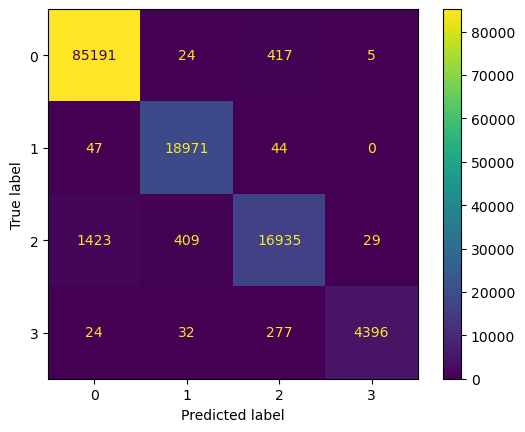

In [34]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=xgb_bow.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_bow.classes_)
disp.plot()

plt.show()

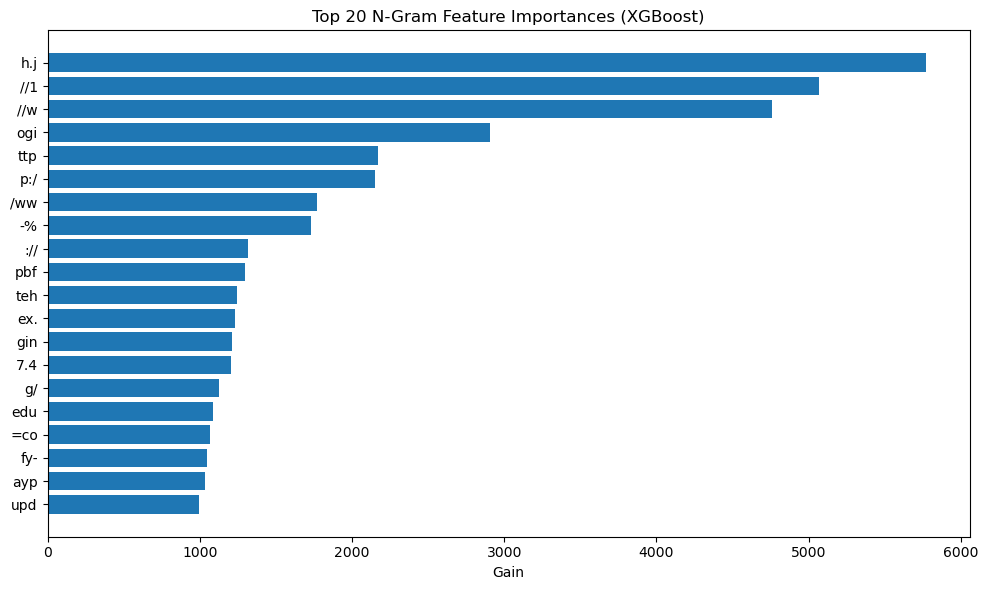

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

booster = xgb_bow.get_booster()
score_dict = booster.get_score(importance_type='gain')

feature_names = vectorizer.get_feature_names_out()
importance_data = []

for feature_id, importance in score_dict.items():
    index = int(feature_id[1:]) 
    if index < len(feature_names):
        ngram = feature_names[index]
        importance_data.append((ngram, importance))

importance_df = pd.DataFrame(importance_data, columns=['N-Gram', 'Gain'])
importance_df = importance_df.sort_values(by='Gain', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['N-Gram'], importance_df['Gain'])
plt.xlabel('Gain')
plt.title('Top 20 N-Gram Feature Importances (XGBoost)')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


In [45]:
# Filter URLs that contain 'h.j'
df_hj = df[df['url'].str.contains('h.j', regex=False)]

df_hj[df_hj['type'] == 'malware']

,url,type
74275,http://photocdn.sohu.com/20150701/mp20878712_1...,malware
127417,http://panthawas.com//jquery-ui-1.10.3.custom/...,malware
268438,http://i01.c.aliimg.com/img/ibank/2014/877/394...,malware
548175,https://mitsui-jyuku.mixh.jp/uploads/N8Mk0.exe,malware
548176,https://mitsui-jyuku.mixh.jp/uploads/9ODNO38B.exe,malware
...,...,...
551051,https://mitsui-jyuku.mixh.jp/uploads/0nH6.exe,malware
551139,http://yagikozublog.mixh.jp/olger_pTtdDTi200.bin,malware
551176,http://mitsui-jyuku.mixh.jp/uploads/4610nH6.exe,malware
551210,http://yagikozublog.mixh.jp/komfu.exe,malware


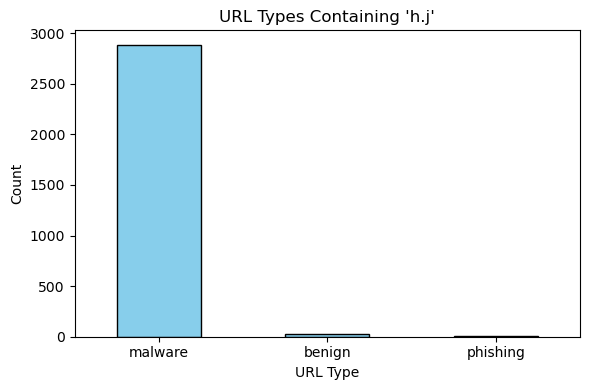

In [42]:
import matplotlib.pyplot as plt

# Count the frequency of each URL type
type_counts = df_hj['type'].value_counts()

# Plot bar chart
plt.figure(figsize=(6, 4))
type_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("URL Types Containing 'h.j'")
plt.xlabel("URL Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Logistic Regression

In [125]:
from sklearn.linear_model import SGDClassifier

parameters = {"alpha":np.logspace(-6, 6, num = 20)}
logistic_clf = SGDClassifier(loss="log_loss", max_iter=1000)
clf = GridSearchCV(logistic_clf, parameters, verbose= 3, cv = 3, n_jobs= -1)
clf.fit(X_train_token, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=SGDClassifier(loss='log_loss'), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 4.28133240e-06, 1.83298071e-05, 7.84759970e-05,
       3.35981829e-04, 1.43844989e-03, 6.15848211e-03, 2.63665090e-02,
       1.12883789e-01, 4.83293024e-01, 2.06913808e+00, 8.85866790e+00,
       3.79269019e+01, 1.62377674e+02, 6.95192796e+02, 2.97635144e+03,
       1.27427499e+04, 5.45559478e+04, 2.33572147e+05, 1.00000000e+06])},
             verbose=3)

In [129]:
pickle.dump(clf, open('logistic_BoW_grid','wb'))

In [130]:
logistic_grid = pickle.load(open('logistic_BoW_grid','rb'))

In [131]:
best_param = logistic_grid.best_params_

In [133]:
logistic_clf_BoW = SGDClassifier(alpha = logistic_grid.best_params_['alpha'], loss= 'log_loss', n_jobs= -1)
logistic_clf_BoW.fit(X_train_token, y_train)

SGDClassifier(alpha=4.281332398719396e-06, loss='log_loss', n_jobs=-1)

In [135]:
y_pred = logistic_clf_BoW.predict(X_test_token)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    107046
           1       0.99      1.00      0.99     23827
           2       0.96      0.94      0.95     23496
           3       0.99      0.93      0.96      5911

    accuracy                           0.98    160280
   macro avg       0.98      0.97      0.97    160280
weighted avg       0.98      0.98      0.98    160280



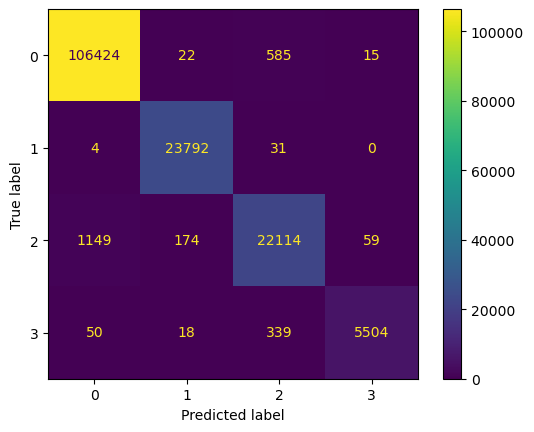

In [136]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=logistic_clf_BoW.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logistic_clf_BoW.classes_)
disp.plot()

plt.show()

### OCSVM

In [64]:
X_normal = X_train_token[y_train == 0]
y_normal = y_train[y_train == 0]

In [75]:
X_subsample, _, y_subsample, _ = train_test_split(
    X_normal, y_normal,
    train_size=20000,
    random_state=42  # ensures reproducibility
)

In [76]:
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.25)
ocsvm.fit(X_subsample)

OneClassSVM(nu=0.25)

In [77]:
y_pred = ocsvm.predict(X_test_token)

In [78]:
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1

y_test[y_test == 2] = 1
y_test[y_test == 3] = 1

              precision    recall  f1-score   support

           0       0.75      0.74      0.75    107046
           1       0.49      0.50      0.50     53234

    accuracy                           0.66    160280
   macro avg       0.62      0.62      0.62    160280
weighted avg       0.66      0.66      0.66    160280



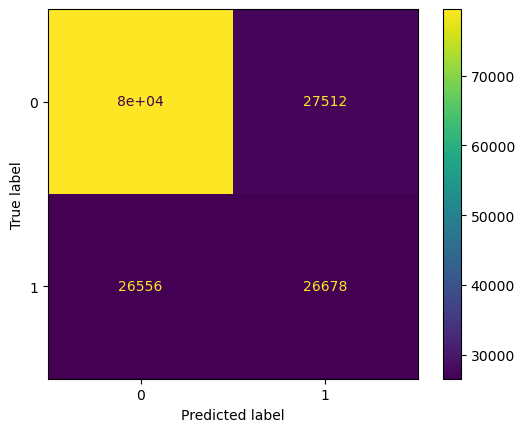

In [79]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()